<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Импорт библиотек

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Методы классификации:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Вспомогательные методы:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Методы измерения метрик классифиукаци:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

## Подготовка данных

Загрузим данные

In [2]:
df = pd.read_csv('datasets/Churn.csv')

Посмотреим на данные

In [3]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Данные уже представленны в нужных форматах.<br>
Очевидно лишними для анализа являются следующие поля:
<ul>
    <li>RowNumber</li>
    <li>CustomerId</li>
</ul><br>
Поле `Surname` – тоже, врдли будеи влиять на какие либо закономерности, но взгляним на его значения:


In [5]:
df['Surname'].value_counts()

Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: Surname, Length: 2932, dtype: int64

In [6]:
df['Surname'].nunique()

2932

Некоторые фамилии повторяются, но во первых не думаю что от фамилии будет что-то зависить, а во вторых, уникальных значений слишком много и т.к. это категориальная переменная, их обраблотка сильно заттруднит анализ. Удалим эти поля:

In [7]:
df = df.drop(['CustomerId', 'RowNumber', 'Surname'], axis=1)

Изучем поле/признак "География":

In [8]:
df['Geography'].nunique()

3

In [9]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Во первых уникальных значений всего 3, что делает опработку таких значений достаточно простой, а во вторых принадлежность клиента к той или иной стране, может существенно повлиять на его предпочтения. 

Изучем поле/признак "Пол":

In [10]:
df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

Два значения, видимо данные старые :) Пропусков нет, можно работать

Изучим дата сет на наличие пропусков:

In [11]:
df.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [12]:
df[df['Tenure'].isna()].head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0


In [13]:
df['Tenure'].isna().mean()

0.0909

Пропускм обнаружены только в поле `Tenure` (crолько лет человек является клиентом банка).<br>
Пропущенных данных около 9% – не много.<br>
Изучим центральные тенденции этого признака:

In [14]:
df['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

<AxesSubplot: >

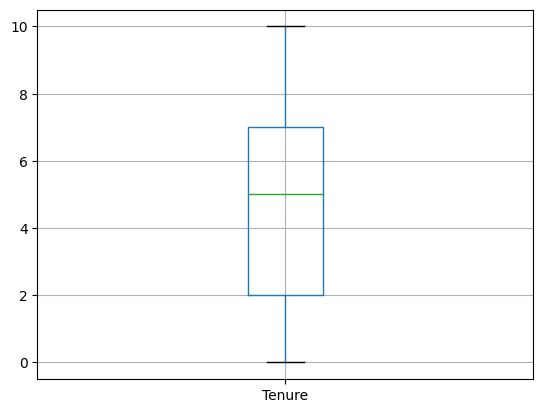

In [15]:
df.boxplot('Tenure')

Значения распределены относительно равномерно, явных выбросов не наблюдаеться.<br>
Заполним пропуски среднеарифметическим:

In [16]:
df['Tenure'].fillna(df['Tenure'].mean(), inplace=True)

Применим кодирование для категориальных признаков. Т.к. в проекте нет порядковых кодегориальных перменных, используем прямое кодирование `pd.get_dummies`.<br>
Сохраним данные в переменную `dfd` – DataFrame dummied

In [17]:
dfd = pd.get_dummies(df, drop_first=True)

Поделим данные на признаки (features) и целевой признак (features).<br>
И следующим шагом, поделим получившиеся данные на обучающую (train) и проверочную (valid) выборки:

In [18]:
target = dfd['Exited']
features =dfd.drop('Exited', axis=1)
train_features, valid_features, train_target, valid_target = train_test_split(features, target, test_size=0.25, random_state=12345) 

### Стандартизация (Масштабирование)

Ещё раз посмотрим на данные получившиеся данные:

In [19]:
dfd.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0


Выделим в отдельный список поля, которые необходимо стандартизировать (привести к единому масштабу)

In [20]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance',  'NumOfProducts', 'EstimatedSalary']

Проведем процидуру стандартизации:

In [21]:
scaler = StandardScaler()
scaler.fit(train_features[numeric])

train_features[numeric] = scaler.transform(train_features[numeric])
valid_features[numeric] = scaler.transform(valid_features[numeric])

train_features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
226,0.442805,-0.841274,1.446176,-1.224577,0.817772,1,1,-1.269750,0,0,0
7756,-0.310897,-0.270730,0.719177,0.641783,-0.896874,1,1,0.960396,0,1,0
2065,-0.259274,-0.556002,1.082676,-1.224577,0.817772,1,0,0.661864,0,0,1
2800,1.217157,1.155631,1.446176,1.290462,0.817772,1,0,-1.039476,0,0,1
7028,0.690598,-1.221637,-0.008661,1.142121,-0.896874,0,0,-0.851729,1,0,1


## Исследование задачи

Проверим баланс классов:

In [22]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Баланс классов заметно смещен в сторону значения `0`. Для начала поробуем построить модели и изучить модели не обращая снимания на дисбаланс

создадим словарь словарь в который будем сохранять метрики:

In [23]:
models_chars = {}

### Функции:

Тестируя разные модели. на потребуеться получать их характеристи и сравнивать их. Что бы не писать каждый раз абзацы кода, папишим две функции:
<ol>
    <li>Функция подсчитывающая характеристики, сохраняющая их в словарь <i>models_chars</i> и выводящая на экран notebook`a</li>
    <li>Функция строящая графики Precision-Recall и ROC кривых</li>
</ol>

In [24]:
def add_model_chars(valid_prediction, valid_target, valid_probabilities, models_type):
    models_chars[models_type] = {
        'accuracy':accuracy_score(valid_prediction, valid_target),
        'recall_score':recall_score(valid_target, valid_prediction),
        'precision_score':precision_score(valid_target, valid_prediction),
        'f1_score':f1_score(valid_target, valid_prediction),
        'auc_roc':roc_auc_score(valid_target, valid_probabilities[:, 1])
    }
    return models_chars[models_type]

In [25]:
def build_graphs(model, valid_features, valid_target, valid_probabilities):
    # valid_probabilities = model.predict_proba(valid_features)
    precision, recall, thresholds = precision_recall_curve(valid_target, valid_probabilities[:, 1])
    fpr, tpr, thresholds = roc_curve(valid_target, valid_probabilities[:, 1]) 

    fig = plt.figure(figsize=(12, 3))
    pr_curve = fig.add_subplot(1, 2, 1)
    roc1_curve = fig.add_subplot(1, 2, 2)

    pr_curve.step(recall, precision, where='post')
    pr_curve.set_xlabel('Recall')
    pr_curve.set_ylabel('Precision')
    pr_curve.set_xlim([0.0, 1.0])
    pr_curve.set_ylim([0.0, 1.0])
    pr_curve.set_title('Кривая Precision-Recall')

    roc1_curve.plot(fpr, tpr)
    roc1_curve.plot([0, 1], [0, 1], linestyle='--')
    roc1_curve.set_xlabel('False Positive Rate')
    roc1_curve.set_ylabel('True Positive Rate')
    roc1_curve.set_xlim([0.0, 1.0])
    roc1_curve.set_ylim([0.0, 1.0])
    roc1_curve.set_title('ROC-кривая')

    return fig.show()

Поочерёдно исследуем модели:

### Логистическая регресски

In [26]:
model =  LogisticRegression(random_state=12345, solver='liblinear', max_iter=1000, )
model.fit(train_features, train_target)
valid_prediction = model.predict(valid_features)
valid_probabilities = model.predict_proba(valid_features)

add_model_chars(valid_prediction, valid_target, valid_probabilities, models_type='LR')

{'accuracy': 0.7972,
 'recall_score': 0.19813084112149532,
 'precision_score': 0.5760869565217391,
 'f1_score': 0.2948539638386648,
 'auc_roc': 0.7585588927730613}

C:\Users\user\AppData\Local\Temp\ipykernel_10280\3054723639.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


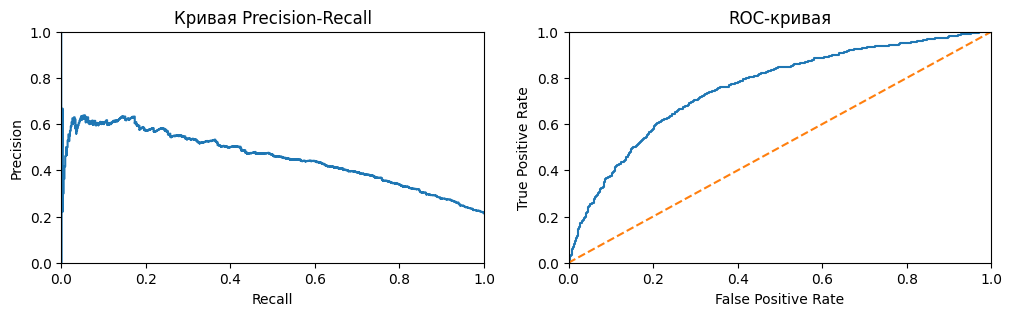

In [27]:
build_graphs(model, valid_features, valid_target, valid_probabilities)

### Дерево решений

In [28]:
best_result = 0

for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, ) 
    model.fit(train_features, train_target) 
    valid_prediction = model.predict(valid_features) 
    result =  accuracy_score(valid_prediction, valid_target)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

print('best accuracy score:', best_result)
print('При depth', best_depth)


best accuracy score: 0.8544
При depth 6


In [29]:
%%time
valid_prediction = best_model.predict(valid_features)
valid_probabilities = best_model.predict_proba(valid_features)
add_model_chars(
    valid_prediction, valid_target, valid_probabilities, 'DTC')

CPU times: total: 15.6 ms
Wall time: 16 ms


{'accuracy': 0.8544,
 'recall_score': 0.4093457943925234,
 'precision_score': 0.8202247191011236,
 'f1_score': 0.546134663341646,
 'auc_roc': 0.8458096121376424}

C:\Users\user\AppData\Local\Temp\ipykernel_10280\3054723639.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


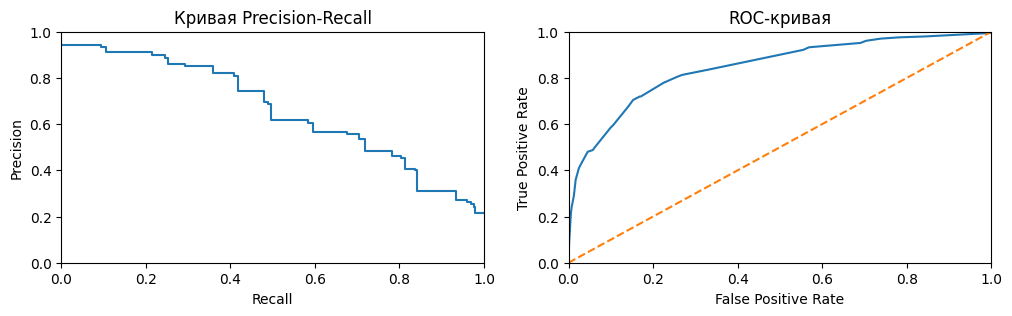

In [30]:
build_graphs(best_model, valid_features, valid_target, valid_probabilities)

### Случайный лес

Сначало подберем лучшее значени глубины:

In [31]:
best_result = 0

for depth in  range(1, 16, 1):
    model = RandomForestClassifier(random_state=12345, n_estimators=3, max_depth=depth, 
    # class_weight='balanced'
    )
    model.fit(train_features, train_target) # обучите модель на тренировочной выборке
    valid_prediction = model.predict(valid_features) # получите предсказания модели на валидационной выборке
    result =  accuracy_score(valid_prediction, valid_target)
    if result > best_result:

        best_result = result
        best_depth = depth

print('best accuracy_score:', best_result)
print('При depth:', best_depth)
print('f1_score', f1_score(valid_target, valid_prediction))

best accuracy_score: 0.8492
При depth: 6
f1_score 0.5188470066518848


При подборе оптимально числа деревьев возникли некоторые трудности, по этому я сохранял результаты в списки и потом построил графики:

In [32]:
best_result_accuracy = 0
best_f1 = 0

f1_list              = []
accuracy_score_list  = []
n_estimators_list    = []

for n_estimators in range(10, 200, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=n_estimators, max_depth=best_depth)
    model.fit(train_features, train_target) # обучите модель на тренировочной выборке
    valid_prediction = model.predict(valid_features) # получите предсказания модели на валидационной выборке
    result =  accuracy_score(valid_prediction, valid_target)
    f1 = f1_score(valid_target, valid_prediction)
    accuracy_score_list.append(result)
    f1_list.append(f1)
    n_estimators_list.append(n_estimators)

    if result > best_result_accuracy:
        best_model = model
        best_result_accuracy = result
        best_n_estimators = n_estimators

    if  f1 > best_f1:
        best_f1 = f1
        best_n_estimators_for_f1 = n_estimators
        accuracy_for_f1 = result


print('best accuracy_score:', best_result_accuracy)
print('При n_estimators:', best_n_estimators)   
print('f1_score', f1_score(valid_target, valid_prediction))
print()
print('best_f1:', best_f1) 
print('При n_estimators:', best_n_estimators_for_f1)
print('При этом accuracy:', accuracy_for_f1)



best accuracy_score: 0.85
При n_estimators: 110
f1_score 0.5019710906701709

best_f1: 0.5110821382007823
При n_estimators: 110
При этом accuracy: 0.85


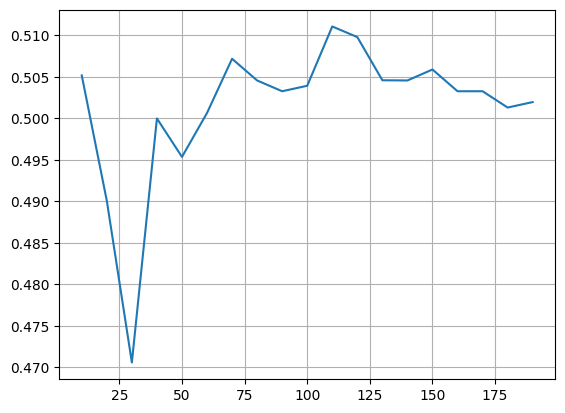

In [33]:
plt.figure()
plt.plot(n_estimators_list, f1_list)
plt.grid()

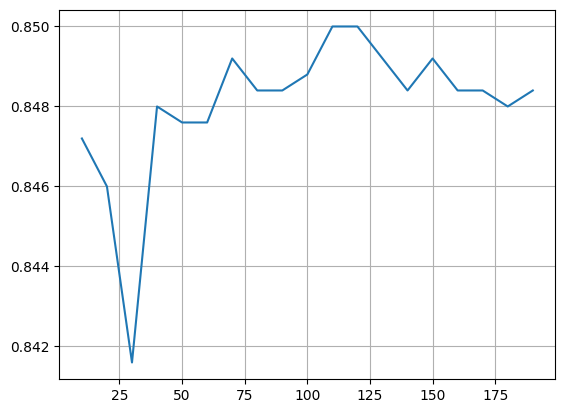

In [34]:
plt.figure()
plt.plot(n_estimators_list, accuracy_score_list)
plt.grid()

Удалось подобрать оптимально оличество деревьев (110). Незначительно просел показатель f1. но это мы поправим при борьбе с дисбалансом

In [35]:
%%time
valid_prediction = best_model.predict(valid_features)
valid_probabilities = best_model.predict_proba(valid_features)
add_model_chars(valid_prediction, valid_target, valid_probabilities, models_type='RFC')

CPU times: total: 125 ms
Wall time: 137 ms


{'accuracy': 0.85,
 'recall_score': 0.3663551401869159,
 'precision_score': 0.8448275862068966,
 'f1_score': 0.5110821382007823,
 'auc_roc': 0.8600390002615872}

C:\Users\user\AppData\Local\Temp\ipykernel_10280\3054723639.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


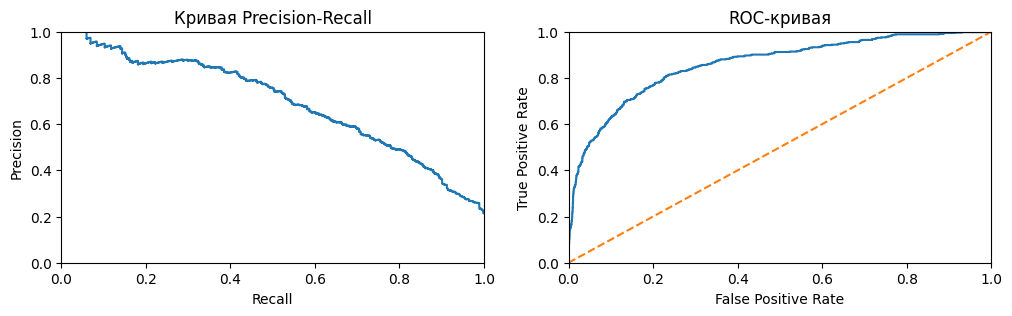

In [36]:
build_graphs(best_model, valid_features, valid_target, valid_probabilities)

In [37]:
pd.DataFrame(models_chars)

,LR,DTC,RFC
accuracy,0.797200,0.854400,0.850000
recall_score,0.198131,0.409346,0.366355
precision_score,0.576087,0.820225,0.844828
f1_score,0.294854,0.546135,0.511082
auc_roc,0.758559,0.845810,0.860039


Самой точной получилась модель Решающего дерева (DTC). И хотя она уступает модели "Случайного леса" в показатели "Площадь ROC кривой", она выигрывает в accuracy и f1_score, а баланс recall/precision по сравнению с со случайным лесом в сторону recall говорит о том, что модель будет точнее определять положительный класса, но и чаще присваевать его классу отрицательному.  Чтобы понять что важнее, надо уже разбираться в бизнес вопросах, а это выходит за рамки задания.<br><br>
А также в пользу модели "Решающего дерева" говорит время исполнения "предсказания": 15 мс против 171 у "Случайного леса", что быстрее более чем в 10 раз.<br><br>
Для дальнейшей работы, перепишем переменную `best_model`, т.к. сейчас в ней шраниться модель "Случайного леса" 

In [38]:
best_result = 0

for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, ) 
    model.fit(train_features, train_target) 
    valid_prediction = model.predict(valid_features) 
    result =  accuracy_score(valid_prediction, valid_target)
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth

print('best accuracy score:', best_result)
print('При depth', best_depth)


best accuracy score: 0.8544
При depth 6


## Борьба с дисбалансом

In [39]:
target.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

### Увеличение выборки и уменьшение  сегментов обучающей выборки

### Для дерева решений

Для борьбы с дисбалансом классов будем использовать измененние велечин выборок, увеличения количества объектов положительном классе и уменьшения в отрицательном. Т.к. нам неизвестно какой вариант лучше, протестируем оба. <br>
Для упрощения работы, напишем соотвествующие функции:

In [40]:
# Увеличение выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [41]:
# Уменьшение выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Переберем одним циклом увеличение и уменьшение выборки одновременно, сохраняя результаты в соответствующие списки:

In [42]:
best_f1_up = 0
best_f1_down = 0
f1_up_list   = []
f1_down_list = []
repeat_list  = []


for repeat in range(1, 50):
    repeat_list.append(repeat)
    # UP
    features_upsampled, target_upsampled = upsample(train_features, train_target, repeat)
    best_model.fit(features_upsampled, target_upsampled)
    valid_prediction_up = best_model.predict(valid_features)
    f1_up =  f1_score(valid_target, valid_prediction_up)
    f1_up_list.append(f1_up)

    # DOWN
    fraction = 1 / repeat
    features_downsampled, target_downsampled = downsample(features, target, fraction)
    best_model.fit(features_downsampled, target_downsampled)
    valid_prediction_down = best_model.predict(valid_features)
    f1_down = f1_score(valid_target, valid_prediction_down)
    f1_down_list.append(f1_down)

    if f1_up > best_f1_up:
        best_f1_up = f1_up
        best_repeat = repeat

    if f1_down > best_f1_down:
        best_f1_down = f1_down
        best_fraction = fraction


print('best f1_up:', best_f1_up)
print('При repeat:', best_repeat) 
print()
print('best best_f1_down:', best_f1_down)
print('При fraction:', best_fraction) 

best f1_up: 0.5983263598326359
При repeat: 5

best best_f1_down: 0.3727530747398297
При fraction: 0.023255813953488372


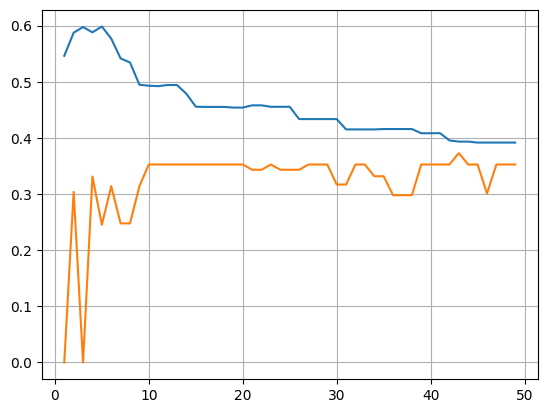

In [43]:
plt.figure()
plt.plot(repeat_list, f1_up_list,  label='UP', )
plt.plot(repeat_list, f1_down_list, label='Down')
plt.grid()

Увеличение количества объектов положительного класса сильнее влият на результат, но и уменьшение отрицательного класса позваляет результатк улучшить.<br>
Так же на графике хорошо видно, как при продолжительном увеличении, так и при уменьшении эффект теряеться.<br><br>
Т.к. оба способа подходять для увелечения эффективности модели, попробуем использовать оба одновременно, перебирая возможные сочетания параметров:

In [44]:
best_f1_up = 0
best_f1_down = 0
metrics = []

for repeat in range(1, 10):
    for i in range(1, 100, 10):
        fraction = i / 100

        features_upsampled, target_upsampled = upsample(train_features, train_target, repeat)
        features_downsampled, target_downsampled = downsample(features_upsampled, target_upsampled, fraction)

        best_model.fit(features_downsampled, target_downsampled)
        valid_prediction = best_model.predict(valid_features)
        f1 = f1_score(valid_target, valid_prediction)
        
        metrics.append({
            'repeat':repeat,
            'fraction':fraction,
            'f1':f1
        })

In [45]:
metrics = pd.DataFrame(metrics)
metrics[metrics['f1'] == metrics['f1'].max()]

,repeat,fraction,f1
4,1,0.41,0.624434


Лучшая комбинация параметров:
<ul>
    <li>repeat = 1</li>
    <li>fraction = 0.4</li>
</ul><br>
`repeat = 1` – означет, что увеличения выборки с объектами положительного класса и вовсе не происходит, но для удобства, так всё и оставми пока.<br>
График ниже, наглядно демонстрирует итеративный перебор двух параметров:

<AxesSubplot: >

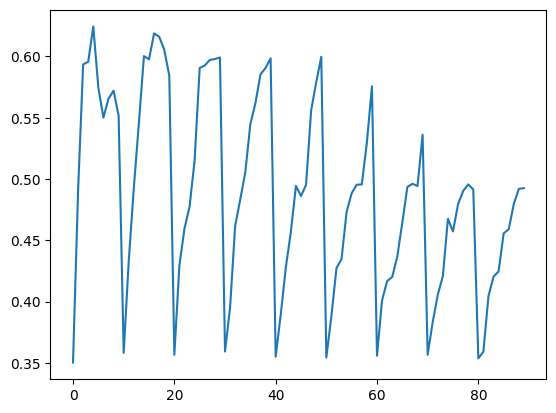

In [46]:
metrics['f1'].plot.line()

In [47]:
repeat = 1
fraction = 0.41

features_upsampled, target_upsampled = upsample(train_features, train_target, repeat)
features_downsampled, target_downsampled = downsample(features_upsampled, target_upsampled, fraction)

best_model.fit(features_downsampled, target_downsampled)
valid_prediction = best_model.predict(valid_features)
valid_probabilities = best_model.predict_proba(valid_features)

add_model_chars(valid_prediction, valid_target, valid_probabilities, models_type='DTC_sample_balanced')

{'accuracy': 0.834,
 'recall_score': 0.6448598130841121,
 'precision_score': 0.6052631578947368,
 'f1_score': 0.6244343891402714,
 'auc_roc': 0.8421426363225606}

Удалось добиться увеличения f1 до приемлмого показателя.

Посмотрим результаты изменяя порог (threshold):

In [48]:
metrics = []
probabilities_one_valid = valid_probabilities[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = [int(probabilit > threshold) for probabilit in probabilities_one_valid] 

    metrics.append({
            'threshold':threshold,
            'precision':precision_score(valid_target, predicted_valid),
            'recall':recall_score (valid_target, predicted_valid),
            'f1':f1_score(valid_target, predicted_valid),
        })

<AxesSubplot: xlabel='threshold'>

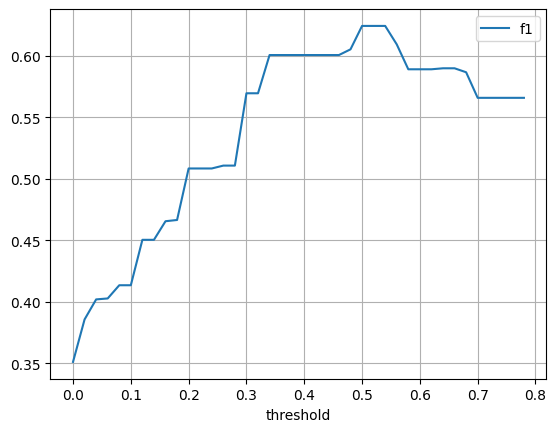

In [49]:
pd.DataFrame(metrics).plot.line(x='threshold', y='f1', grid=True)

In [50]:
metrics = pd.DataFrame(metrics)
metrics[metrics['f1'] == metrics['f1'].max()]

,threshold,precision,recall,f1
25,0.50,0.605263,0.64486,0.624434
26,0.52,0.605263,0.64486,0.624434
27,0.54,0.605263,0.64486,0.624434


In [51]:
valid_prediction = [int(probabilit > 0.52) for probabilit in probabilities_one_valid] 

In [52]:
add_model_chars(valid_prediction, valid_target, valid_probabilities, models_type='DTC_sample_balanced_thresholded')

{'accuracy': 0.834,
 'recall_score': 0.6448598130841121,
 'precision_score': 0.6052631578947368,
 'f1_score': 0.6244343891402714,
 'auc_roc': 0.8421426363225606}

Добиться улучшения модели за счёт изменения порога не удалось. Но ранее, при выполнении работы, я пробовал методы борьбы с дисбалансом на модели "Случайны лес" и там удалос достичь более внушительных результатов. По этому, повторю все теже дествия ещё раз. но со случайным лесом:

### Для случайного леса

Снова обучим модель:

In [53]:
best_result = 0

for depth in  range(1, 16, 1):
    model = RandomForestClassifier(random_state=12345, n_estimators=3, max_depth=depth, 
    # class_weight='balanced'
    )
    model.fit(train_features, train_target) # обучите модель на тренировочной выборке
    valid_prediction = model.predict(valid_features) # получите предсказания модели на валидационной выборке
    result =  accuracy_score(valid_prediction, valid_target)
    if result > best_result:

        best_result = result
        best_depth = depth

print('best accuracy_score:', best_result)
print('При depth:', best_depth)
print('f1_score', f1_score(valid_target, valid_prediction))

best accuracy_score: 0.8492
При depth: 6
f1_score 0.5188470066518848


In [54]:
best_result_accuracy = 0
best_f1 = 0

f1_list              = []
accuracy_score_list  = []
n_estimators_list    = []

for n_estimators in range(10, 200, 10):
    model = RandomForestClassifier(random_state=12345, n_estimators=n_estimators, max_depth=best_depth)
    model.fit(train_features, train_target) # обучите модель на тренировочной выборке
    valid_prediction = model.predict(valid_features) # получите предсказания модели на валидационной выборке
    result =  accuracy_score(valid_prediction, valid_target)
    f1 = f1_score(valid_target, valid_prediction)
    accuracy_score_list.append(result)
    f1_list.append(f1)
    n_estimators_list.append(n_estimators)

    if result > best_result_accuracy:
        best_model = model
        best_result_accuracy = result
        best_n_estimators = n_estimators

    if  f1 > best_f1:
        best_f1 = f1
        best_n_estimators_for_f1 = n_estimators
        accuracy_for_f1 = result


print('best accuracy_score:', best_result_accuracy)
print('При n_estimators:', best_n_estimators)   
print('f1_score', f1_score(valid_target, valid_prediction))
print()
print('best_f1:', best_f1) 
print('При n_estimators:', best_n_estimators_for_f1)
print('При этом accuracy:', accuracy_for_f1)



best accuracy_score: 0.85
При n_estimators: 110
f1_score 0.5019710906701709

best_f1: 0.5110821382007823
При n_estimators: 110
При этом accuracy: 0.85


Повторим исследование влияния метода (увелечение/уменьшение выборки) на показатели модели:

In [55]:
best_f1_up = 0
best_f1_down = 0
f1_up_list   = []
f1_down_list = []
repeat_list  = []


for repeat in range(1, 50):
    repeat_list.append(repeat)
    # UP
    features_upsampled, target_upsampled = upsample(train_features, train_target, repeat)
    best_model.fit(features_upsampled, target_upsampled)
    valid_prediction_up = best_model.predict(valid_features)
    f1_up =  f1_score(valid_target, valid_prediction_up)
    f1_up_list.append(f1_up)

    # DOWN
    fraction = 1 / repeat
    features_downsampled, target_downsampled = downsample(features, target, fraction)
    best_model.fit(features_downsampled, target_downsampled)
    valid_prediction_down = best_model.predict(valid_features)
    f1_down = f1_score(valid_target, valid_prediction_down)
    f1_down_list.append(f1_down)

    if f1_up > best_f1_up:
        best_f1_up = f1_up
        best_repeat = repeat

    if f1_down > best_f1_down:
        best_f1_down = f1_down
        best_fraction = fraction


print('best f1_up:', best_f1_up)
print('При repeat:', best_repeat) 
print()
print('best best_f1_down:', best_f1_down)
print('При fraction:', best_fraction) 

best f1_up: 0.6361974405850092
При repeat: 3

best best_f1_down: 0.4221556886227545
При fraction: 0.25


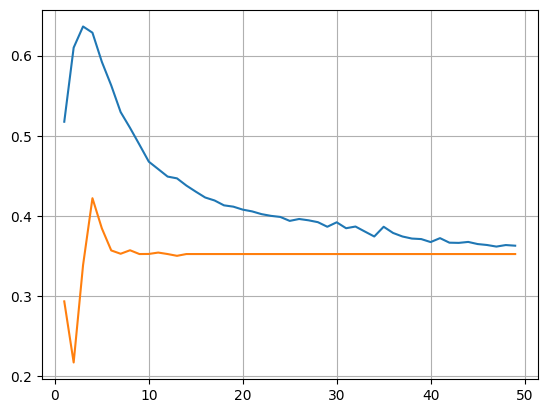

In [56]:
plt.figure()
plt.plot(repeat_list, f1_up_list,  label='UP', )
plt.plot(repeat_list, f1_down_list, label='Down')
plt.grid()

Даже график при работе со случайным лесом выглядит более интересным и плавным. Но вы вод такой же

In [57]:
best_f1_up = 0
best_f1_down = 0
metrics = []

for repeat in range(1, 10):
    for i in range(1, 100, 10):
        fraction = i / 100

        features_upsampled, target_upsampled = upsample(train_features, train_target, repeat)
        features_downsampled, target_downsampled = downsample(features_upsampled, target_upsampled, fraction)

        best_model.fit(features_downsampled, target_downsampled)
        valid_prediction = best_model.predict(valid_features)
        f1 = f1_score(valid_target, valid_prediction)
        
        metrics.append({
            'repeat':repeat,
            'fraction':fraction,
            'f1':f1
        })

In [58]:
metrics = pd.DataFrame(metrics)
metrics[metrics['f1'] == metrics['f1'].max()]

,repeat,fraction,f1
16,2,0.61,0.645921


Лучшая комбинация параметров:
<ul>
    <li>repeat = 2</li>
    <li>fraction = 0.61</li>
</ul><br>
В отличии от "дерева" в "лесу" мы уже что-то увеличиваем, а что-то уменьшаем

<AxesSubplot: >

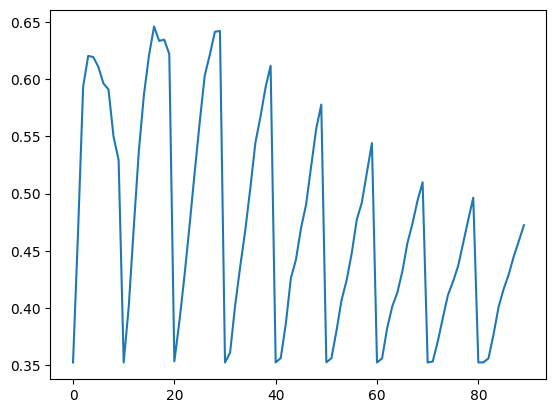

In [59]:
metrics['f1'].plot.line()

In [60]:
repeat = 2
fraction = 0.61

features_upsampled, target_upsampled = upsample(train_features, train_target, repeat)
features_downsampled, target_downsampled = downsample(features_upsampled, target_upsampled, fraction)

best_model.fit(features_downsampled, target_downsampled)
valid_prediction = best_model.predict(valid_features)
valid_probabilities = best_model.predict_proba(valid_features)

add_model_chars(valid_prediction, valid_target, valid_probabilities, models_type='DTC_sample_balanced')

{'accuracy': 0.8316,
 'recall_score': 0.7177570093457943,
 'precision_score': 0.5871559633027523,
 'f1_score': 0.6459209419680404,
 'auc_roc': 0.8632841073934032}

После обработки обучающей выборки "Случайный лес" покуазывает больший прирост f1, чем "дерево"

Посмотрим результаты изменяя порог (threshold):

In [61]:
metrics = []
probabilities_one_valid = valid_probabilities[:, 1]

for threshold in np.arange(0, 0.8, 0.02):
    predicted_valid = [int(probabilit > threshold) for probabilit in probabilities_one_valid] 

    metrics.append({
            'threshold':threshold,
            'precision':precision_score(valid_target, predicted_valid),
            'recall':recall_score (valid_target, predicted_valid),
            'f1':f1_score(valid_target, predicted_valid),
        })

<AxesSubplot: xlabel='threshold'>

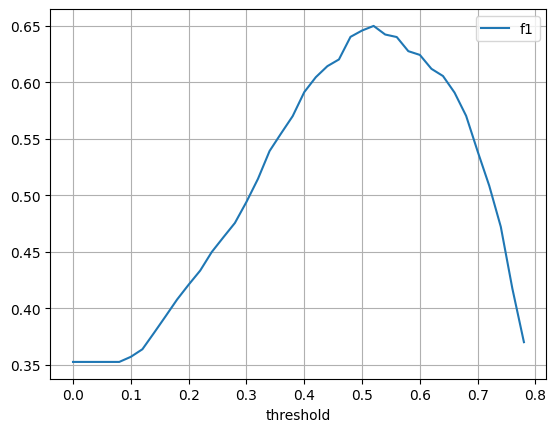

In [62]:
pd.DataFrame(metrics).plot.line(x='threshold', y='f1', grid=True)

График, вновь, более плавный

In [63]:
metrics = pd.DataFrame(metrics)
metrics[metrics['f1'] == metrics['f1'].max()]

,threshold,precision,recall,f1
26,0.52,0.622222,0.680374,0.65


In [64]:
valid_prediction = [int(probabilit > 0.52) for probabilit in probabilities_one_valid] 

In [65]:
add_model_chars(valid_prediction, valid_target, valid_probabilities, models_type='RFC_sample_balanced_thresholded')

{'accuracy': 0.8432,
 'recall_score': 0.680373831775701,
 'precision_score': 0.6222222222222222,
 'f1_score': 0.6499999999999999,
 'auc_roc': 0.8632841073934032}

In [66]:
pd.DataFrame(models_chars)

,LR,DTC,RFC,DTC_sample_balanced,DTC_sample_balanced_thresholded,RFC_sample_balanced_thresholded
accuracy,0.797200,0.854400,0.850000,0.831600,0.834000,0.843200
recall_score,0.198131,0.409346,0.366355,0.717757,0.644860,0.680374
precision_score,0.576087,0.820225,0.844828,0.587156,0.605263,0.622222
f1_score,0.294854,0.546135,0.511082,0.645921,0.624434,0.650000
auc_roc,0.758559,0.845810,0.860039,0.863284,0.842143,0.863284


## Тестирование модели

Проверим нашу модель (пусть остаётся "лес") на валидационной выборке

In [67]:
prediction = best_model.predict(valid_features)

Создаим target-набор сотоящий только из отрицательных меток: 

In [68]:
target_pred_constant = pd.Series(0, valid_target.index)

In [69]:
accuracy_score(valid_target, prediction)

0.8316

In [70]:
accuracy_score(valid_target, target_pred_constant)

0.786

Наша модель показывает большую точность чем "случайные" ответы. Считаю проверку пройденой :)

## Общий вывод проекта

В общем выводе счита важным отметисть следующее: до примененния методов борьбы с дисбалансом классов, модель "Решаюшего дерева" имела более высокие показатели, но модель "случайного леса" лучше реагировала на борьбу с дисбалансом и обогнала "дерево" по показателям. Но с учетом не большой разници в итоговых показателях и того что обе модели превзошли плановоге значение `f1 = 0.59`, а модель "дерева" обрабатывает данные в 10 раз быстрее, возможно правельным решением для бизнеса будет, использовать в production`е именно её.

Сравнение показателей моделей:

In [71]:
pd.DataFrame(models_chars)

,LR,DTC,RFC,DTC_sample_balanced,DTC_sample_balanced_thresholded,RFC_sample_balanced_thresholded
accuracy,0.797200,0.854400,0.850000,0.831600,0.834000,0.843200
recall_score,0.198131,0.409346,0.366355,0.717757,0.644860,0.680374
precision_score,0.576087,0.820225,0.844828,0.587156,0.605263,0.622222
f1_score,0.294854,0.546135,0.511082,0.645921,0.624434,0.650000
auc_roc,0.758559,0.845810,0.860039,0.863284,0.842143,0.863284


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: задача исследована
    - [ ]  Исследован баланс классов
    - [ ]  Изучены модели без учёта дисбаланса
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 3: учтён дисбаланс
    - [ ]  Применено несколько способов борьбы с дисбалансом
    - [ ]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [ ]  Исследована метрика *AUC-ROC*